In [1]:
import numpy as np
import matplotlib.pyplot as plt
# If you need to import from a local utils.py, uncomment and adjust the following lines:
import sys
import os
import jax.numpy as jnp
# Construct the full path to the folder
folder_path = r'C:\Users\Petrb\Desktop\DTU\3rdSemester\02477_BAYESIAN_MACHINE_LEARNING'

# Add the folder to the Python path
sys.path.append(folder_path)

# Now you can import the utils module
from utils import *
from kernel_gaussian_classes import * 

# Part 2: Gaussian process regression

Let $\mathcal{D} = \{(x_n, y_n)\}_{n=1}^N$ be a dataset for regression, where $x_n \in \mathbb{R}$ and $y_n \in \mathbb{R}$ are the input and output for the $n$'th observation, respectively.

Assume a Gaussian process regression model of the form

$$
y_n = f(x_n) + \epsilon_n,
$$

where $f \sim \mathcal{GP}(0, k(x, x'))$ and $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$ is i.i.d additive Gaussian noise.

Assume the following kernel:

$$
k_1(x, x') = \kappa^2 \exp \left( -\frac{1}{2\ell^2} \|x - x'\|_2^2 \right)
$$

and the following dataset with $N = 8$ observations

$$
\begin{align*}
x &= [-2.17, 1.99, 0.57, -3.01, -1.16, 3.30, -4.85, -0.86] \\
y &= [0.88, 0.46, -0.06, 0.98, 0.45, 0.88, -0.66, 0.05]
\end{align*}
$$

such that $x_n$ and $y_n$ are the $n$'th elements in $x$ and $y$, respectively.


In [5]:
# --------------------------------------------------
# 1.  Hyper‑parameters & noise level (user‑defined)
# --------------------------------------------------
kappa = 0.7                        # Kernel amplitude  (scalar)
length_scale = 0.5 * np.sqrt(2)    # Length‑scale ℓ   (scalar)
sigma = 1.0 / 5.0                  # Observation‑noise std‑dev σ (scalar)

X = np.array([[-2.17], [1.99], [0.57], [-3.01], [-1.16], [3.30], [-4.85], [-0.86]])
Y = np.array([[0.88], [0.46], [-0.06], [0.98], [0.45], [0.88], [-0.66], [0.05]])


## Question 2.1: Determine the likelihood for the regression model in eq. (4).


> ###  SOLVED IN GOODNOTES

Assume the following values for the hyperparameters:

$$
\kappa = 0.7, \quad \ell = \frac{1}{2}\sqrt{2}, \quad \sigma = \frac{1}{5}.
$$

## Question 2.2: Determine the analytical prior predictive distribution $p(y^*|x^* = 1)$ for $y^* = y(x^*)$.


In [9]:
# PRIOR PREDICTIVE DISTRIBUTION AT A SINGLE INPUT
# ----------------------------------------------
# Goal
# ----
# Compute the *prior* predictive variance of an observation y* at x* = 1
# for a Gaussian process with
#     • RBF kernel  kappa · exp(‑||x‑x'||² / (2ℓ²))
#     • iid Gaussian observation noise with variance σ².
#
# Because **no training data are conditioned on**, the predictive distribution
# is
#     y* | x*  ~ 𝓝(m(x*),  k(x*,x*) + σ² ),   (Eq. P‑1)
# where m(x*)=0 by default (change if you use a non‑zero mean function).
#
# Implementation below computes the scalar quantity
#     C := k(x*,x*) + σ²          (shape: (1,1))
# which is the variance term on the RHS of (Eq. P‑1).

# --------------------------------------------------
# 1.  Hyper‑parameters (must be defined elsewhere)
# --------------------------------------------------
# kappa        — signal variance (scalar)
# length_scale — length‑scale ℓ  (scalar)
# sigma        — observation‑noise std‑dev σ (scalar)
#
# These variables are assumed to exist in the notebook / script.  An example
# assignment is commented out below—uncomment if you need standalone use.
#
# kappa = 0.7
# length_scale = 0.5 * np.sqrt(2)
# sigma = 1.0 / 5.0

# --------------------------------------------------
# 2.  Test input x* = 1  (shape: (1,1))
# --------------------------------------------------
xstar = np.array([[1]])

# --------------------------------------------------
# 3.  Kernel function (already implemented elsewhere)
# --------------------------------------------------
# from <your‑module> import rbf
# def rbf(A, B, *, length_scale, kappa): ...

# --------------------------------------------------
# 4.  Prior predictive variance (Eq. P‑1)
# --------------------------------------------------
C = rbf(xstar, xstar, length_scale=length_scale, kappa=kappa) + sigma ** 2  # (1,1)

print("prior mean m(x*): 0.0 (assumed)")
print("prior variance C  :", C.ravel())


prior mean m(x*): 0.0 (assumed)
prior variance C  : [0.53]


## Question 2.3: Determine the analytical posterior predictive distribution $p(y^*|y, x^* = 227)$ for $y^* = y(x^*)$.


In [10]:
# Gaussian‑process posterior for a **single** test input
# ----------------------------------------------------
# This script computes the *posterior* mean (\mu_*) and variance (\sigma_*^2)
# of a Gaussian process at one test location `X_star`, given
#    • training inputs  X  (shape: [n_train, d])
#    • training targets Y  (shape: [n_train, 1]  **or** [n_train,])
#    • hyper‑parameters of an RBF kernel: amplitude \kappa and length scale \ell
#    • observation‑noise standard deviation \sigma (homoskedastic, iid)
#
# Mathematical formulas
# --------------------
# Let
#   K   = k(X,  X)   + \sigma^2 I   ∈ ℝ^{n×n}
#   k_* = k(X,  X_*)               ∈ ℝ^{n×1}
#   c   = k(X_*,X_*)  + \sigma^2       (scalar)
#
# Then the posterior predictive distribution at X_* is
#   f_* |D, X_*  ~  𝓝( μ_*,  σ_*^2 ),  where
#
#        μ_*     =  k_*ᵀ  K^{-1}  Y              (Eq. 1)
#        σ_*^2   =  c  −  k_*ᵀ  K^{-1}  k_*      (Eq. 2)
#
# Implementation details
# ----------------------
# • We use NumPy’s broadcasting; the shapes are explicitly annotated below.
# • Only a single test point is handled here (shape [1, d]); extend X_star
#   to shape [m, d] and adjust the algebra to predict multiple points.

# --------------------------------------------------
# 2.  Data  (must be defined elsewhere in your code)
# --------------------------------------------------
# X : training inputs         shape (n_train, d)
# Y : training targets        shape (n_train, 1) **or** (n_train,)
# Provide them before running this snippet.

# Example placeholder (delete when real data are known):
# X = np.linspace(0,10,8)[:,None]     # 8 training points in 1‑D
# Y = np.sin(X) + 0.1*np.random.randn(*X.shape)

# --------------------------------------------------
# 3.  Test input (single point)
# --------------------------------------------------
X_star = np.array([[227]])          # shape (1, d)

# --------------------------------------------------
# 5.  Build covariance blocks
# --------------------------------------------------
# c      : scalar (shape (1,1))                — see Eq. 2 RHS first term
# k      : shape (1, n_train) **transposed later** — Eq. 1 & Eq. 2
# C (≡K) : shape (n_train, n_train)            — training covariance matrix

c = rbf(X_star, X_star, length_scale=length_scale, kappa=kappa) + sigma ** 2  # shape (1,1)

k = rbf(X_star, X, length_scale=length_scale, kappa=kappa)                    # shape (1, n_train)

C = rbf(X, X, length_scale=length_scale, kappa=kappa) + sigma ** 2 * np.eye(X.shape[0])  # (n_train, n_train)

# --------------------------------------------------
# 6.  Solve the linear systems for K^{-1}Y and K^{-1}k_*
# --------------------------------------------------
# For numerical stability, a Cholesky decomposition is preferred; we use
# np.linalg.inv here for pedagogical clarity.

K_inv = np.linalg.inv(C)                  # (n_train, n_train)

mu = k @ K_inv @ Y                       # shape (1,1) — Eq. 1
sigma2 = c - k @ K_inv @ k.T             # shape (1,1) — Eq. 2

print("posterior mean μ_* :", mu.ravel())
print("posterior var  σ_*²:", sigma2.ravel())


posterior mean μ_* : [0.]
posterior var  σ_*²: [0.53]


## Question 2.4: Marginal Likelihood

Determine the analytical expression for the marginal likelihood $p(y|\kappa, \ell, \sigma)$ and compute the numerical value of $\log p(y|\kappa, \ell, \sigma)$.


In [11]:
from scipy.stats import multivariate_normal as mvn

D = rbf(X, X, length_scale=length_scale, kappa=kappa) + (sigma**2 * np.identity(8)) # (n_train, n_train)

print(mvn.logpdf(Y.ravel(), np.zeros(8), D))

-6.651211355122703


In [13]:
gp = GaussianProcessRegression(X, Y, StationaryIsotropicKernel(squared_exponential))

print(f"Log marginal likelihood: {gp.log_marginal_likelihood(kappa=kappa, lengthscale=length_scale, sigma=sigma)}")

Log marginal likelihood: -6.651211738586426


In [17]:
kern = StationaryIsotropicKernel(squared_exponential)
C = kern.contruct_kernel(X, X,kappa,length_scale) + (sigma**2 * np.identity(8)) # (n_train, n_train)
print(f"Log marginal likelihood: {mvn.logpdf(Y.ravel(), np.zeros(8), C)}")

Log marginal likelihood: -6.651211511640666


## Question 2.5: Analytical Posterior Distributions

Determine the analytical posterior distribution $p(f^*|y, x^* = 1)$ for $f^* = f(x^*)$ as well as the analytical posterior predictive distribution for $p(y^*|y, x^* = 1)$ for $y^* = y(x^*)$.


In [6]:
X_star = np.array([[1]])          # shape (1, d)

# --------------------------------------------------
# 5.  Build covariance blocks
# --------------------------------------------------
# c      : scalar (shape (1,1))                — see Eq. 2 RHS first term
# k      : shape (1, n_train) **transposed later** — Eq. 1 & Eq. 2
# C (≡K) : shape (n_train, n_train)            — training covariance matrix

c = rbf(X_star, X_star, length_scale=length_scale, kappa=kappa)
k = rbf(X_star, X, length_scale=length_scale, kappa=kappa)                    # shape (1, n_train)

K = rbf(X, X, length_scale=length_scale, kappa=kappa)  # (n_train, n_train)


mean_inv = np.linalg.inv(K + (sigma**2 * np.eye(X.shape[0]))) # (n_train, n_train)
post_mean = k @ mean_inv @ Y # shape (1,1) — Eq. 1

print(post_mean.ravel())


post_cov = c - k @ mean_inv @ k.T # shape (1,1) — Eq. 2
print(post_cov.ravel())

[0.07054075]
[0.13887564]


## Consider now a different kernel

$$
k_2(x, x') = c_1 \left( 1 + \frac{\|x - x'\|}{2\ell^2} \right)^{-1} + c_2 x x',
$$

with hyperparameters $c_1, c_2, \ell > 0$.

## Question 2.6: Kernel Properties

Determine whether $k_2$ is a stationary kernel and determine whether $k_2$ is an isotropic kernel.


The kernel is not stationary, although it depends on the distance between $x$ and $x'$ through the term $\|x - x'\|$. The kernel is not isotropic, as it depends on dot product $x x'$. 

The kernel is neither isotropic, because depends on a dot product of $x$ and $x'$, and not only on the distance between them. 

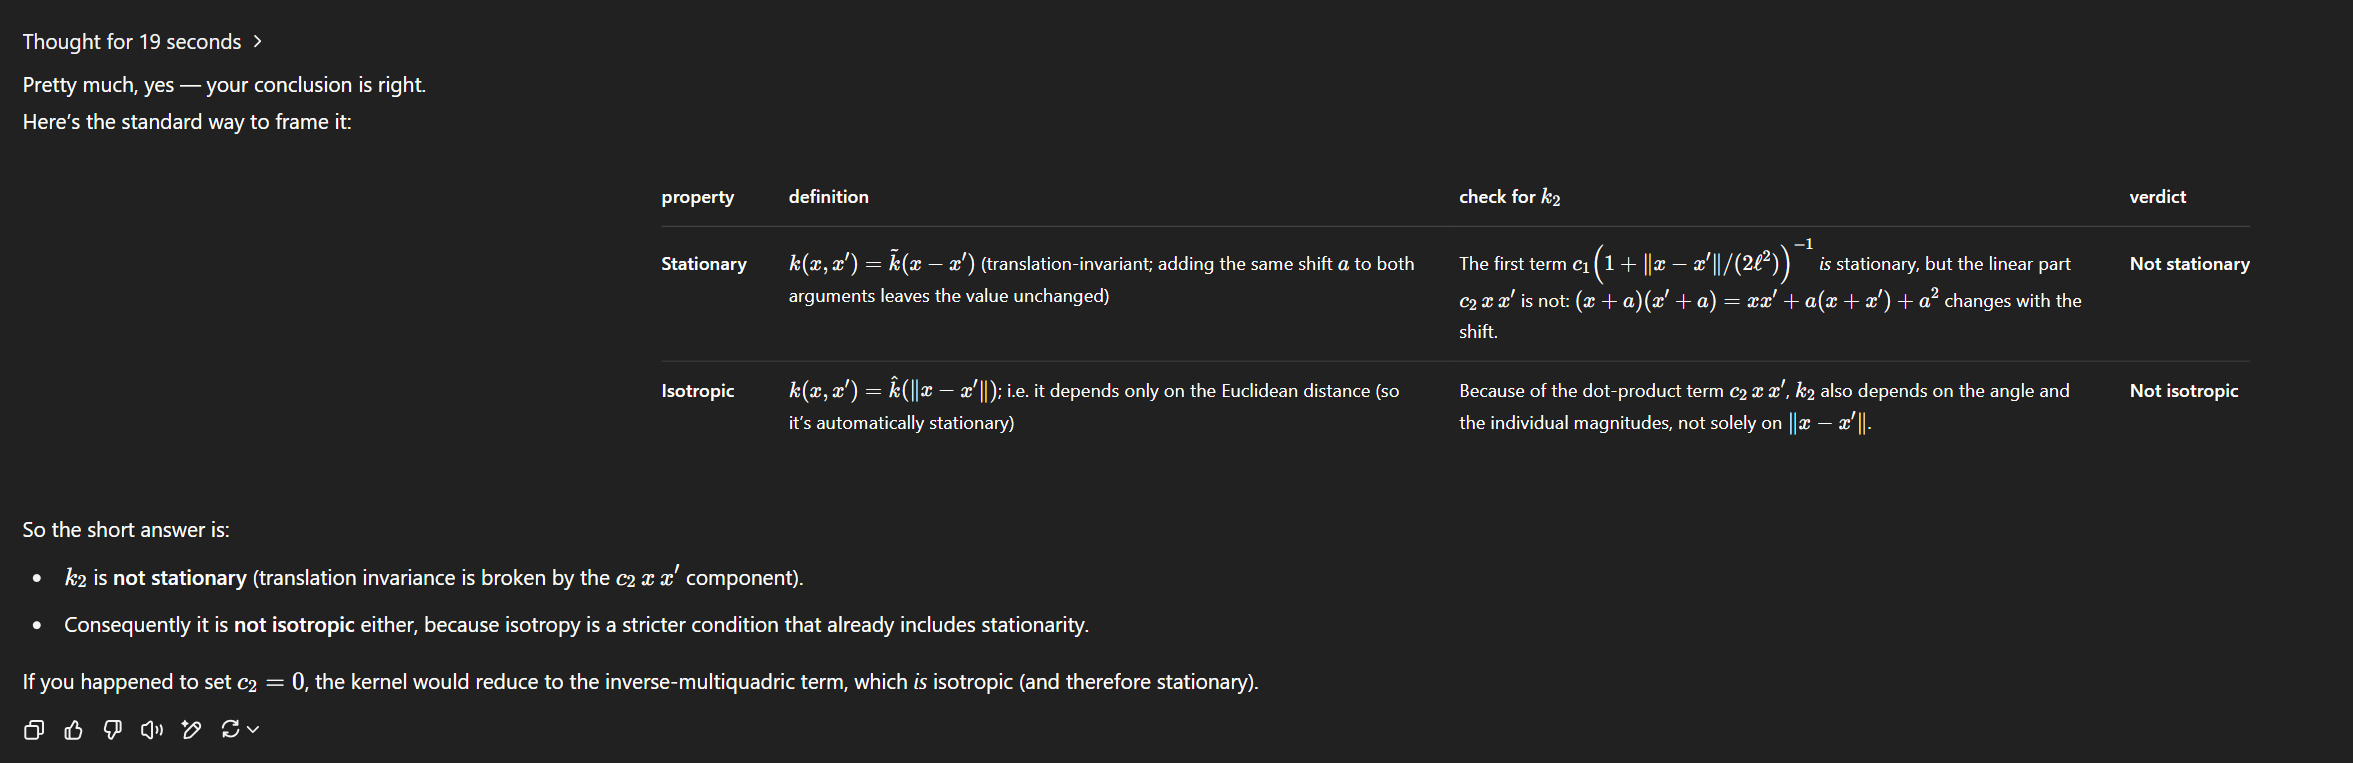

## Question 2.7: Prior Covariance

Compute the prior covariance between $f = [f(x_1), f(x_2), \ldots, f(x_8)]$ and $f^* = f(x^*)$ for $x^* = -1$ for $c_1 = c_2 = 1$ and $\ell = \frac{1}{\sqrt{2}}$.

In [21]:
def abs_kernel(X1, X2, length_scale=1.0, c1=1.0, c2=1.0, debug=False):
    """
    Computes a “squared exponential style” kernel (here using an L₁ based form) plus a linear term.
    
    Parameters
    ----------
    X1 : np.ndarray, shape (n1, d)
        First batch of points (n1 points in d dimensions).
    X2 : np.ndarray, shape (n2, d)
        Second batch of points (n2 points in d dimensions).
    length_scale : float
        Lengthscale parameter ell > 0 (default 1.0).
    variance : float
        Variance (amplitude) parameter σ² (default 1.0).  Currently not used in your return statement,
        but you could multiply the whole kernel by this if desired.
    
    Returns
    -------
    K : np.ndarray, shape (n1, n2)
        Kernel matrix where
          K[i,j] = 1 * (1 + (‖X1[i] − X2[j]‖₁ / (2 ℓ²)))⁻¹  +  X1[i] · X2[j]
    """
    # ensure length_scale is positive and nonzero
    l = np.abs(length_scale) + 1e-12
    

    
    # 2) Compute pairwise differences via broadcasting:
    #    diff[i,j,k] = X1[i,k] - X2[j,k]
    #    shape of diff: (n1, n2, d)
    diff = X1[:, None, :] - X2[None, :, :]
    
    # 3) Sum absolute differences over the last axis to get L1 distance:
    #    sqdist[i,j] = sum_k |diff[i,j,k]|
    #    shape of sqdist: (n1, n2)*
    absdist = np.sum(np.abs((diff)), axis=2)
    
    # 4) Compute the kernel:
    #    A) “Squared‐exponential–style” term (but using L1 distance here):
    #         (1 + sqdist / (2 ℓ²))⁻¹
    #    B) Plus a linear term X1·X2ᵀ
    #    Final shape: (n1, n2)
    
    
    if debug:
        print("*" * 50)
        print("Debugging information:")
        
        print("Length scale (l):", l)
        # 1) Print shapes for debugging
        #   X1 shape: (n1, d)
        print("X1 shape before:", X1.shape)
        #   After adding a new axis: (n1, 1, d)
        print("X1[:, None, :] shape:", X1[:, None, :].shape)
        #   X2 shape: (n2, d)
        print("X2 shape before:", X2.shape)
        #   After adding a new axis: (1, n2, d)
        print("X2[None, :, :] shape:", X2[None, :, :].shape)
        #  diff shape: (n1, n2, d)
        print("diff shape:", diff.shape)
        #  sqdist shape: (n1, n2)
        print("sqdist shape:", sqdist.shape)
        #  K shape: (n1, n2)
        #print("K shape:", (1 * (1 + (sqdist / (2 * l**2)))**(-1) + X1 @ X2.T).shape)
        print("*" * 50)
        print("*" * 50)
     
    return c1 * (1 + absdist / (2 * l**2))**(-1) + c2 * (X1 @ X2)

In [22]:
X_star = np.array([[-1]])   
prior_cov = abs_kernel(X, X_star, length_scale=1.0/np.sqrt(2), c1=1.0, c2=1.0)

In [24]:
print("prior covariance:", prior_cov.shape)

prior covariance: (8, 1)
